# Strategies

This notebook aims to test a neural network using different word embedding methods.

**Word embedding methods:**

| Method       | Definition                                                                 | Advantages                                                                                     | Limitations                                                                 |
|--------------|-----------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| Word2Vec     | Represents words as dense vectors in a continuous space, capturing semantic relationships based on context. | Effective for capturing semantic relationships; widely used in NLP tasks.                     | Requires large datasets; struggles with out-of-vocabulary words.            |
| Glove        | Generates word embeddings by factorizing a co-occurrence matrix, capturing both local and global semantic relationships. | Captures both local and global context; effective for text classification and sentiment analysis. | Computationally expensive; requires pre-computed co-occurrence statistics.  |
| USE (Universal Sentence Encoder) | Produces embeddings for entire sentences rather than individual words, leveraging deep learning models. | Captures sentence-level semantics; pre-trained models available for quick use.                | Higher computational cost; less effective for word-level tasks.             |
| BERT | Bidirectional Encoder Representations from Transformers; contextual word embeddings that consider the entire context of a word from both directions. | Superior contextual understanding; pre-trained on massive datasets; captures complex language patterns. | Computationally expensive; requires significant memory; longer training times than traditional methods. |

# Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import time
import warnings
from collections import Counter
import pickle
import tempfile
from tqdm import tqdm

# NLTK
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             fbeta_score, make_scorer, matthews_corrcoef, balanced_accuracy_score,
                             classification_report, confusion_matrix, roc_auc_score, roc_curve)


import numpy as np

import mlflow
import mlflow.keras


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ikusawalaetitia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', True)

# Data preparation

## Import

In [3]:
path_to_sample = "../data/processed_sample_tweets.csv"

sample_df = pd.read_csv(path_to_sample, encoding='utf-8')
# Display the first few rows of the dataframe
sample_df.head(10)

,target,ids,date,user,text,processed_text_lem,advanced_processed_text_lem,processed_text_stem,advanced_processed_text_stem
0,0,2065378704,2009-06-07 08:28:25,juliaindelicate,@christt I really wanted to go i didn't get t...,< mention > really wanted go not get go anal b...,< mention > really wanted go not get go anal b...,< mention > realli want go not get go ani anal...,< mention > realli want go not get go ani anal...
1,0,2198776518,2009-06-16 16:33:19,hxcfairy,Finally home from my sisters and I'm so tired,finally home sister tired,finally home sister tired,final home sister tire,final home sister tire
2,0,2258118867,2009-06-20 15:24:59,TranceGemini613,"I really, really wish I'd known all the stuff ...",really really wish would known stuff james tel...,really really wish would known stuff james tel...,realli realli wish would known stuff jame tell...,realli realli wish would known stuff jame tell...
3,0,1755733793,2009-05-10 09:53:26,jwatkins5377,Can officially say I have been at work EVERYDA...,officially say work everyday week ... bad toda...,officially say work everyday week ... bad toda...,offici say work everyday thi week ... bad toda...,offici say work everyday thi week ... bad toda...
4,0,1881082418,2009-05-22 03:32:26,davelee,#FirstRecord The Mr Blobby single Sorry folks.,< hashtag > mr blobby single sorry folk .,< hashtag > mr lobby single sorry folk .,< hashtag > mr blobbi singl sorri folk .,< hashtag > mr lobbi singl sorri folk .
5,0,2045678642,2009-06-05 11:04:38,johnny101,My turkey and ham salad wrap is not sitting we...,turkey ham salad wrap not sitting well .,turkey ham salad wrap not sitting well .,turkey ham salad wrap not sit well .,turkey ham salad wrap not sit well .
6,0,2323712552,2009-06-25 01:17:50,Matt_Whiting,Footy Trainin Was called off Now i Dont kn...,footy trainin wa called dont know ? laugh loud,footy training wa called not know ? lot,footi trainin wa call dont know ? laugh loud,footi train wa call not know ? lot
7,0,2200119346,2009-06-16 18:27:54,JoePaley17,Just got bacl from ftbl summer school tomorrow,got bacl ftbl summer school tomorrow,got back feel summer school tomorrow,got bacl ftbl summer school tomorrow,got back feel summer school tomorrow
8,0,2247872282,2009-06-19 19:45:15,trexsandwich,"@writesfortea Cool teachers are the best, but ...",< mention > cool teacher best never lasted sch...,< mention > cool teacher best never lasted sch...,< mention > cool teacher best never last schoo...,< mention > cool teacher best never last schoo...
9,0,1835988160,2009-05-18 07:09:13,renzzee,"@rediska08 awts. friday, parteeey! hahaha! sa...",< mention > awts . friday parteey ! hahaha ! s...,< mention > awts . friday parteey ! hahaha ! s...,< mention > awt . friday parteey ! hahaha ! sa...,< mention > awt . friday parteey ! hahaha ! sa...


## MLFlow setup

In [6]:
import os
from dotenv import load_dotenv
import time

import mlflow
from mlflow.models import infer_signature
from mlflow.tracking import MlflowClient


from tqdm import tqdm


# For scikit-learn
mlflow.sklearn.autolog()

# Configuring MLflow
load_dotenv()
tracking_uri = os.getenv("MLFLOW_TRACKING_URI")
mlflow.set_tracking_uri(tracking_uri)
print(f"MLflow Tracking URI: {tracking_uri}")

MLflow Tracking URI: http://localhost:8081


In [4]:
# Create a new MLflow Experiment
experiment_name = "P7-Sentiments_Analysis_neural_network"

# Check if the experiment exists, create it if it doesn't
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    print(f"Created new experiment '{experiment_name}' with ID: {experiment_id}")
else:
    experiment_id = experiment.experiment_id
    print(f"Using existing experiment '{experiment_name}' with ID: {experiment_id}")

# Set the experiment
mlflow.set_experiment(experiment_name)

Using existing experiment 'P7-Sentiments_Analysis_neural_network' with ID: 859618380264734882


<Experiment: artifact_location='mlflow-artifacts:/859618380264734882', creation_time=1760707139984, experiment_id='859618380264734882', last_update_time=1760707139984, lifecycle_stage='active', name='P7-Sentiments_Analysis_neural_network', tags={}>

# Functions

In [5]:
def log_metrics_summary_table(metrics, dataset_type, embedding_type):
    """
    Creates and logs a detailed metrics summary table as a CSV file.

    Args:
        metrics: Dictionary of evaluation metrics
        dataset_type: 'validation' or 'test'
        embedding_type: Type of embedding used (w2v, fasttext, glove)
    """
    # Create a DataFrame from the metrics dictionary
    metrics_df = pd.DataFrame([metrics])

    # Add embedding type and dataset information
    metrics_df['embedding'] = embedding_type
    metrics_df['dataset'] = dataset_type

    # Save as CSV
    csv_path = f"../data/{dataset_type}_metrics_{embedding_type}.csv"
    metrics_df.to_csv(csv_path, index=False)

    # Log to MLflow
    mlflow.log_artifact(csv_path, artifact_path="metrics_summaries")

    return metrics_df

## Classes

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


print("Version:", tf.__version__)
print("Available GPUs :", tf.config.list_physical_devices('GPU'))


Version: 2.17.1
Available GPUs : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay)
from gensim.models import Word2Vec, FastText
import os

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

class NeuralTweetClassifier:
    """
        A classifier that uses neural networks (LSTM, RNN, Bidirectional LSTM) with
        different word embeddings (Word2Vec, FastText, GloVe) to classify tweets.
    """
    def __init__(self, embedding:str, embedding_dim: int=100, units: int=128,
                max_length: int=100, model_type: str='LSTM', base_dir: str = "../"):
        """
            Initialize the NeuralTweetClassifier.

            Args:
                embedding (str): Type of embedding to use ('w2v', 'fasttext', 'glove')
                embedding_dim (int): Dimension of the embedding vectors
                units (int): Number of units in the RNN layers
                max_length (int): Maximum length of input sequences
                model_type (str): Type of model to use ('LSTM', 'RNN', 'Bidirectional_LSTM')
                base_dir (str): Base directory for saving artifacts
        """
        self.embedding = embedding
        self.embedding_dim = embedding_dim
        self.units = units
        self.max_length = max_length
        self.tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
        self.model_type = model_type
        self.model = None

        # Directory structure
        self.base_dir = base_dir
        self.artifacts_dir = os.path.join(self.base_dir, "artifacts")
        self.models_dir = os.path.join(self.base_dir, "models")
        self.checkpoints_dir = os.path.join(self.base_dir, "checkpoints")

        # Validate inputs
        valid_model_types = ['LSTM', 'RNN', 'Bidirectional_LSTM', 'GRU', 'Bidirectional_GRU']
        valid_embeddings = ['w2v', 'fasttext', 'glove']

        if model_type not in valid_model_types:
            raise ValueError(f"model_type must be one of {valid_model_types}")
        if embedding not in valid_embeddings:
            raise ValueError(f"embedding must be one of {valid_embeddings}")

    # === TOKENIZER ===
    def fit_tokenizer(self, texts: pd.Series):
        """
        Fits the tokenizer on the input texts and returns padded sequences.

        Args:
            texts (pd.Series): Series of text strings to tokenize

        Returns:
            np.ndarray: Padded sequences of token IDs
        """
        # Tokenize texts
        self.tokenizer.fit_on_texts(texts)
        # Convert texts to sequences
        sequences = self.tokenizer.texts_to_sequences(texts)
        # Uniform length by padding/truncating
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

        return padded_sequences

    # === EMBEDDING ===
    def build_embedding_matrix(self, texts: pd.Series, use_pretrained: bool = True):
        """
        Builds embedding matrix for the tokenized vocabulary.

        Args:
            texts (pd.Series): Series of text strings to build embeddings for

        Returns:
            np.ndarray: Embedding matrix with shape (vocab_size, embedding_dim)
        """
        word_index = self.tokenizer.word_index
        vocab_size = len(word_index) + 1
        embedding_matrix = np.zeros((vocab_size, self.embedding_dim))

        if self.embedding == 'glove':
            import gensim.downloader as api
            model = api.load("glove-twitter-100")
            has_wv_attr = hasattr(model, "wv")
        elif self.embedding == 'w2v' and use_pretrained:
            # Try to load pre-trained Word2Vec
            try:
                model = Word2Vec.load(f"../models/pretrained_w2v_{self.embedding_dim}.model")
                has_wv_attr = hasattr(model, "wv")
            except:
                # Fallback to training on training data only
                model = Word2Vec(sentences=[s.split() for s in texts],
                            vector_size=self.embedding_dim, window=5,
                            min_count=1, workers=4)
                has_wv_attr = hasattr(model, "wv")
                model.save(f"../models/pretrained_w2v_{self.embedding_dim}.model")
        elif self.embedding == 'fasttext':
            try:
                model = FastText.load(f"../models/pretrained_fasttext_{self.embedding_dim}.model")
                has_wv_attr = hasattr(model, "wv")
            except FileNotFoundError:
                model = FastText(sentences=[s.split() for s in texts], vector_size=self.embedding_dim,
                                window=5, min_count=1, workers=4)
                has_wv_attr = hasattr(model, "wv")
                model.save(f"../models/pretrained_fasttext_{self.embedding_dim}.model")
            has_wv_attr = hasattr(model, "wv")
        else:
            model = Word2Vec(sentences=[s.split() for s in texts], vector_size=self.embedding_dim, window=5,
                            min_count=1, workers=4)
            has_wv_attr = hasattr(model, "wv")

        # Fill embedding matrix with word vectors
        for word, i in word_index.items():
            if has_wv_attr and word in model.wv:
                embedding_matrix[i] = model.wv[word]
            elif not has_wv_attr and word in model:
                embedding_matrix[i] = model[word]

        return embedding_matrix

    # === MODEL ===
    def build_model(self, vocab_size: int, embedding_matrix: np.ndarray):
        """
        Builds neural network model with the specified architecture.

        Args:
            vocab_size (int): Size of the vocabulary
            embedding_matrix (np.ndarray): Pre-built embedding matrix

        Returns:
            keras.Model: Built model
        """
        self.model = Sequential()
        self.model.add(Embedding(input_dim=vocab_size, output_dim=self.embedding_dim, weights=[embedding_matrix], input_length=self.max_length, trainable=True))

        if self.model_type == 'RNN':
            with tf.device("/CPU:0"):
                self.model.add(SimpleRNN(self.units, return_sequences=False, dropout=0.3))


        elif self.model_type == 'LSTM':
            self.model.add(LSTM(self.units, return_sequences=False, dropout=0.3))

        elif self.model_type == 'Bidirectional_LSTM':
            self.model.add(Bidirectional(LSTM(self.units, return_sequences=False, dropout=0.3)))

        elif self.model_type == 'GRU':
            self.model.add(GRU(self.units, return_sequences=False, dropout=0.3))

        elif self.model_type == 'Bidirectional_GRU':
            self.model.add(Bidirectional(GRU(self.units, return_sequences=False, dropout=0.3)))


        self.model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

        return self.model

    # === METRICS ===
    def compute_metrics(self, y_true, y_pred, prefix=""):
        """
        Calculates and returns various classification metrics.

        Args:
            y_true (np.ndarray): True labels
            y_pred (np.ndarray): Predicted probabilities
            prefix (str): Prefix for MLflow logging (e.g., "val_" or "test_")

        Returns:
            dict: Dictionary containing metrics
        """
        y_bin = (y_pred > 0.5).astype(int)

        negatives = np.sum(y_true == 0)
        accuracy = accuracy_score(y_true, y_bin)
        specificity = np.sum((y_pred < 0.5) & (y_true == 0)) / negatives if negatives > 0 else np.nan
        precision = precision_score(y_true, y_bin)
        recall = recall_score(y_true, y_bin)
        f1 = f1_score(y_true, y_bin)
        auc = roc_auc_score(y_true, y_pred)

        # Log metrics with prefix for distinguishing between validation and test
        mlflow.log_metric(f"{prefix}accuracy", accuracy)
        mlflow.log_metric(f"{prefix}specificity", specificity)
        mlflow.log_metric(f"{prefix}precision", precision)
        mlflow.log_metric(f"{prefix}recall", recall)
        mlflow.log_metric(f"{prefix}f1_score", f1)
        mlflow.log_metric(f"{prefix}roc_auc", auc)
        return {
            'accuracy': accuracy,
            'specificity': specificity,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'roc_auc': auc
        }

    # === TRAINING ===
    def train_and_evaluate(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        """Trains the LSTM model and evaluates it on the validation set.

        Args:
            X_train (np.ndarray): Training feature vectors.
            y_train (np.ndarray): Training labels.
            X_val (np.ndarray): Validation feature vectors.
            y_val (np.ndarray): Validation labels.
            epochs (int, optional): Number of training epochs. Defaults to 10.
            batch_size (int, optional): Batch size for training. Defaults to 32.
        Returns:
            dict: Dictionary containing evaluation metrics on the validation set.
        """
        if self.model is None:
            raise ValueError("The model has not been built. Call build_model first.")

        model_name = f"{self.model_type}_{self.embedding}"

        # Log model parameters
        mlflow.log_param("embedding", self.embedding)
        mlflow.log_param("embedding_dim", self.embedding_dim)
        mlflow.log_param("units", self.units)
        mlflow.log_param("model_type", self.model_type)
        mlflow.log_param("max_length", self.max_length)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)

        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ]

        # Training
        start_time = time.time()
        history = self.model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=epochs,
                                batch_size=batch_size,
                                verbose=1,
                                callbacks=callbacks)
        training_time = time.time() - start_time
        mlflow.log_metric("training_time", training_time)

        # Learning curves
        self._plot_learning_curves(history, model_name)

        # Calculate validation metrics
        y_val_pred = self.model.predict(X_val).flatten()
        val_metrics = self.compute_metrics(y_val, y_val_pred, prefix="val_")

        # Create ROC curve and confusion matrix
        self._plot_roc_curve(y_val, y_val_pred, model_name)
        self._plot_confusion_matrix(y_val, y_val_pred, model_name)

        # Save and log model using MLflow properly
        try:
            # Create model signature for MLflow
            signature = infer_signature(X_val[:1], self.model.predict(X_val[:1]))

            # Log model to MLflow - fix the artifact path and name
            mlflow.keras.log_model(
                self.model,
                artifact_path=model_name,  # This is the directory within the MLflow run
                registered_model_name=model_name,  # Register the model in the Model Registry
                signature=signature
            )
            print(f"Model successfully logged to MLflow at path: {model_name}")

            # Save tokenizer in a temporary location just for MLflow logging
            with tempfile.NamedTemporaryFile(suffix=".pkl", delete=False) as tmp_file:
                pickle.dump(self.tokenizer, tmp_file)
                tokenizer_tmp_path = tmp_file.name

            mlflow.log_artifact(tokenizer_tmp_path, artifact_path=f"{model_name}/tokenizer")
            os.remove(tokenizer_tmp_path)
        except Exception as e:
            print(f"Error logging model or tokenizer to MLflow: {str(e)}")

        return val_metrics

    # === VISUALIZATION METHODS ===
    def _plot_learning_curves(self, history, model_name):
        """Plot and save learning curves."""
        plt.figure(figsize=(12, 5))

        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{model_name} - Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{model_name} - Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()

        # Save figure using a temporary file to avoid persisting artifacts locally
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file:
            curve_path = tmp_file.name

        plt.savefig(curve_path)
        mlflow.log_artifact(curve_path, artifact_path="learning_curve")
        os.remove(curve_path)
        plt.close()

    def _plot_roc_curve(self, y_true, y_pred, model_name):
        """Plot and save ROC curve."""
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {model_name}")
        plt.legend(loc="lower right")

        # Save figure using a temporary file
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file:
            roc_path = tmp_file.name

        plt.savefig(roc_path)
        mlflow.log_artifact(roc_path, artifact_path="roc_curve")
        os.remove(roc_path)
        plt.close()

    def _plot_confusion_matrix(self, y_true, y_pred, model_name):
        """Plot and save confusion matrix."""
        # Convert predictions to binary
        y_pred_binary = (y_pred > 0.5).astype(int)

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred_binary)

        # Plot
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
        plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

        # Save figure using a temporary file
        with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmp_file:
            cm_path = tmp_file.name

        plt.savefig(cm_path)
        mlflow.log_artifact(cm_path, artifact_path="confusion_matrix")
        os.remove(cm_path)
        plt.close()

    # === FIT & TEST ===
    def fit(self, text: pd.Series, labels: pd.Series, test_size:float = 0.2, val_split:float = 0.2,epochs: int=10, batch_size: int=32):
        """
        Complete pipeline: preprocess data, build model, train, and evaluate.

        Args:
            text (pd.Series): Input text data
            labels (pd.Series): Target labels
            test_size (float): Proportion of data for testing
            val_split (float): Proportion of training data for validation
            epochs (int): Number of training epochs
            batch_size (int): Batch size for training

        Returns:
            dict: Dictionary with validation and test metrics
        """
        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(
            text, labels, test_size=test_size,
            random_state=42, stratify=labels
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_split,
            random_state=42, stratify=y_temp
        )

        # Tokenize and pad sequences
        self.tokenizer.fit_on_texts(X_train)
        train_sequences = self.tokenizer.texts_to_sequences(X_train)
        train_padded_sequences = pad_sequences(train_sequences, maxlen=self.max_length, padding='post', truncating='post')
        val_sequences = self.tokenizer.texts_to_sequences(X_val)
        val_padded_sequences = pad_sequences(val_sequences, maxlen=self.max_length, padding='post', truncating='post')
        test_sequences = self.tokenizer.texts_to_sequences(X_test)
        test_padded_sequences = pad_sequences(test_sequences, maxlen=self.max_length, padding='post', truncating='post')

        # Print data info
        print(f"Label distribution:\n{labels.value_counts()}")
        print(f"Sequence example (first 3):\n{train_sequences[:3]}")

        # Prepare model
        vocab_size = len(self.tokenizer.word_index) + 1
        embedding_matrix = self.build_embedding_matrix(X_train)
        self.build_model(vocab_size, embedding_matrix)


        val_metrics = self.train_and_evaluate(train_padded_sequences, y_train, val_padded_sequences, y_val, epochs, batch_size)
        # Test on held-out data
        y_test_pred = self.model.predict(test_padded_sequences).flatten()
        test_metrics = self.compute_metrics(y_test, y_test_pred, prefix="test_")
        print("Test metrics:", test_metrics)

        return {"val": val_metrics, "test": test_metrics}

    # === PREDICT ===
    def predict(self, texts: pd.Series):
        """
        Predict sentiment for new texts.

        Args:
            texts (pd.Series): Series of text strings to predict

        Returns:
            np.ndarray: Array of predicted labels (0 or 1)
        """
        if self.model is None:
            raise ValueError("The model has not been built or trained. Call fit first.")

        # Preprocess and tokenize the input texts
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded_sequences = pad_sequences(sequences, maxlen=self.max_length, padding='post', truncating='post')

        # Predict using the trained model
        predictions = self.model.predict(padded_sequences).flatten()
        predicted_labels = (predictions > 0.5).astype(int)

        return predicted_labels

    # === SAVE & LOAD ===
    def save(self, model_path=None):
        """
        Save the model and tokenizer.

        Args:
            model_path (str, optional): Path to save the model. If None, uses default.

        Returns:
            tuple: Paths to the saved model and tokenizer
        """
        if self.model is None:
            raise ValueError("No model to save. Train a model first.")

        # Use default path if none provided
        if model_path is None:
            model_name = f"{self.model_type}_{self.embedding}"
            model_dir = os.path.join(self.models_dir, model_name)
            os.makedirs(model_dir, exist_ok=True)
            model_path = os.path.join(model_dir, "model.keras")
            tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
        else:
            model_dir = os.path.dirname(model_path)
            os.makedirs(model_dir, exist_ok=True)
            tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")

        # Save model and tokenizer
        self.model.save(model_path)
        with open(tokenizer_path, "wb") as f:
            pickle.dump(self.tokenizer, f)

        print(f"Model saved to {model_path}")
        print(f"Tokenizer saved to {tokenizer_path}")

        return model_path, tokenizer_path

    @classmethod
    def load(cls, model_path, tokenizer_path, embedding, model_type='LSTM'):
        """
        Load a saved model and tokenizer.

        Args:
            model_path (str): Path to the saved model
            tokenizer_path (str): Path to the saved tokenizer
            embedding (str): Embedding type used ('w2v', 'fasttext', 'glove')
            model_type (str): Type of model ('LSTM', 'RNN', 'Bidirectional_LSTM')

        Returns:
            NeuralTweetClassifier: Instance with loaded model and tokenizer
        """
        # Create instance
        instance = cls(embedding=embedding, model_type=model_type)

        # Load model and tokenizer
        instance.model = load_model(model_path)
        with open(tokenizer_path, "rb") as f:
            instance.tokenizer = pickle.load(f)

        print(f"Model loaded from {model_path}")
        print(f"Tokenizer loaded from {tokenizer_path}")

        return instance

# Training

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np

# TODO
def cross_validate_neural_model(config, document, labels, n_splits=5, random_state=42):
    """
    Perform cross-validation for neural network models.

    Args:
        config (dict): Configuration dictionary with model parameters
        document (pd.Series): Text data
        labels (pd.Series): Target labels
        n_splits (int): Number of cross-validation folds
        random_state (int): Random seed for reproducibility

    Returns:
        dict: Dictionary with cross-validation metrics
    """
    # Setup cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Store metrics for each fold
    fold_metrics = []

    # Run name for MLflow
    run_name = f"CV_{config['model_type']}_{config['embedding']}_{config['epochs']}epochs"

    with mlflow.start_run(run_name=run_name):
        # Log configuration parameters
        for key, value in config.items():
            mlflow.log_param(key, value)
        mlflow.log_param("n_splits", n_splits)

        # Perform cross-validation
        for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(labels)), labels)):
            print(f"\nFold {fold+1}/{n_splits}")

            # Split data for this fold
            X_train_fold = document.iloc[train_idx]
            y_train_fold = labels.iloc[train_idx]
            X_test_fold = document.iloc[test_idx]
            y_test_fold = labels.iloc[test_idx]

            # Create and train model
            model = NeuralTweetClassifier(
                embedding=config['embedding'],
                embedding_dim=config['embedding_dim'],
                units=config['units'],
                max_length=config['max_length'],
                model_type=config['model_type']
            )

            # Train and evaluate on this fold
            with mlflow.start_run(nested=True, run_name=f"fold_{fold+1}"):
                fold_results = model.fit(
                    text=X_train_fold,
                    labels=y_train_fold,
                    epochs=config['epochs'],
                    batch_size=config['batch_size']
                )

                # Store metrics
                test_metrics = fold_results.get('test', {})
                test_metrics['fold'] = fold + 1
                fold_metrics.append(test_metrics)

                # Log fold metrics with prefix
                for metric_name, metric_value in test_metrics.items():
                    mlflow.log_metric(f"fold_{fold+1}_{metric_name}", metric_value)

        # Calculate and log average metrics across folds
        avg_metrics = {}
        for metric in ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'specificity']:
            values = [fold[metric] for fold in fold_metrics if metric in fold]
            if values:
                avg_metrics[f"cv_{metric}_mean"] = np.mean(values)
                avg_metrics[f"cv_{metric}_std"] = np.std(values)

                # Log to MLflow
                mlflow.log_metric(f"cv_{metric}_mean", avg_metrics[f"cv_{metric}_mean"])
                mlflow.log_metric(f"cv_{metric}_std", avg_metrics[f"cv_{metric}_std"])

        # Create visualization of CV results
        plot_cv_metrics(fold_metrics, config)

    return {
        'fold_metrics': fold_metrics,
        'avg_metrics': avg_metrics,
        'config': config
    }

def plot_cv_metrics(fold_metrics, config):
    """Plot cross-validation metrics across folds"""
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'specificity']

    plt.figure(figsize=(14, 10))

    # Prepare data for plotting
    plot_data = []
    for fold_idx, fold in enumerate(fold_metrics):
        for metric in metrics_to_plot:
            if metric in fold:
                plot_data.append({
                    'fold': fold_idx + 1,
                    'metric': metric.capitalize(),
                    'value': fold[metric]
                })

    if not plot_data:
        return

    # Create dataframe for seaborn
    plot_df = pd.DataFrame(plot_data)

    # Plot
    sns.barplot(x='metric', y='value', hue='fold', data=plot_df)
    plt.title(f"Cross-Validation Metrics - {config['model_type']} with {config['embedding']} embeddings")
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    # Save figure
    plot_path = f"cv_metrics_{config['model_type']}_{config['embedding']}.png"
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path, artifact_path="cv_metrics")
    plt.close()


[1/12] Testing LSTM with w2v embeddings
Training LSTM with w2v embeddings...
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.5005 - loss: 0.7372 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.4997 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.4976 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.4999 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
250/250 ━━━━━━━━━━━━━━━━━

,model_type,embedding,accuracy,specificity,f1_score,precision,recall,roc_auc
4,Bidirectional_LSTM,glove,0.7807,0.7656,0.783962,0.772471,0.7958,0.866317
11,Bidirectional_GRU,glove,0.7795,0.7730,0.780924,0.775913,0.7860,0.867155
9,Bidirectional_GRU,w2v,0.7657,0.7818,0.761866,0.774540,0.7496,0.842904
5,Bidirectional_LSTM,fasttext,0.7646,0.7684,0.763702,0.766626,0.7608,0.847418
10,Bidirectional_GRU,fasttext,0.7582,0.8428,0.735853,0.810785,0.6736,0.847727
3,Bidirectional_LSTM,w2v,0.7557,0.7298,0.761868,0.743107,0.7816,0.838919
0,LSTM,w2v,0.5000,1.0000,0.000000,0.000000,0.0000,0.500000
1,LSTM,fasttext,0.5000,1.0000,0.000000,0.000000,0.0000,0.500000
2,LSTM,glove,0.5000,1.0000,0.000000,0.000000,0.0000,0.500000
6,GRU,w2v,0.5000,0.0000,0.666667,0.500000,1.0000,0.500000


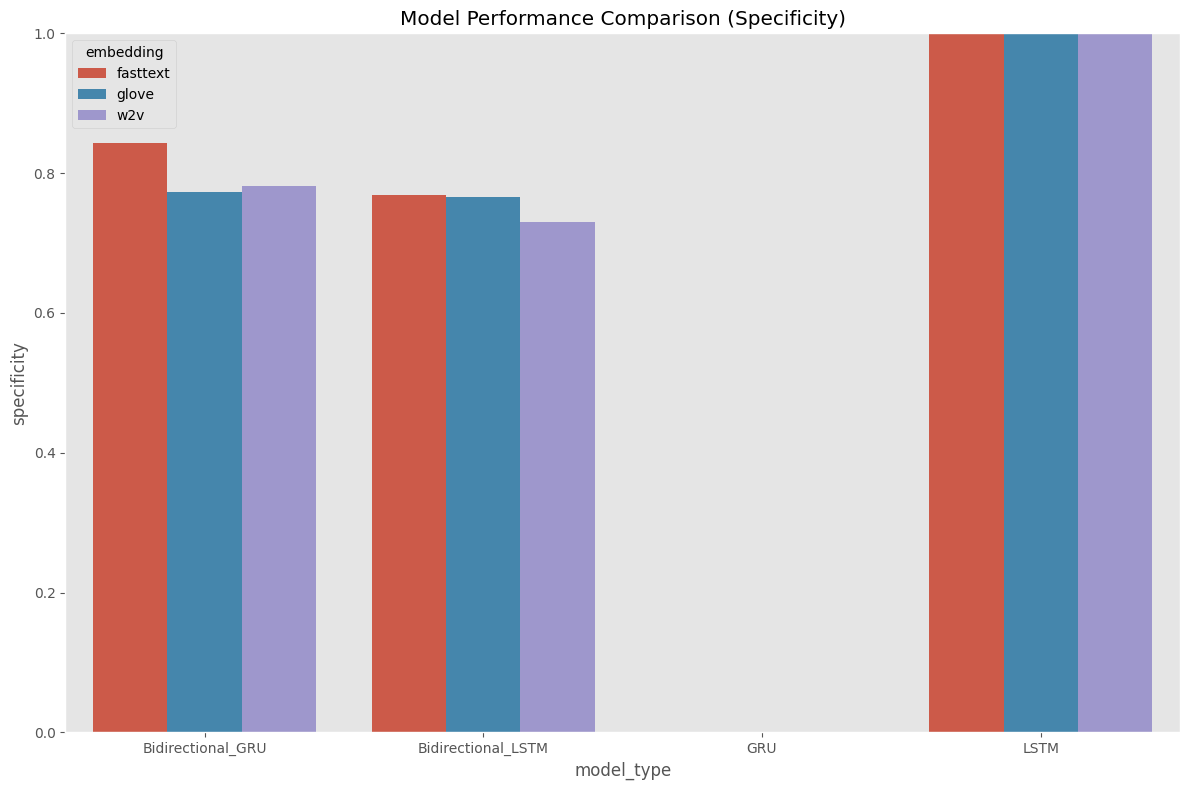

In [22]:
# Define comprehensive testing configurations
configurations = [
    # LSTM configurations with different embeddings
    {
        'model_type': 'LSTM',
        'embedding': 'w2v',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'LSTM',
        'embedding': 'fasttext',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'LSTM',
        'embedding': 'glove',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },

    # Bidirectional_LSTM configurations
    {
        'model_type': 'Bidirectional_LSTM',
        'embedding': 'w2v',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'Bidirectional_LSTM',
        'embedding': 'glove',  # GloVe often works well with bidirectional models
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'Bidirectional_LSTM',
        'embedding': 'fasttext',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'GRU',
        'embedding': 'w2v',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'GRU',
        'embedding': 'fasttext',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'GRU',
        'embedding': 'glove',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 5,
        'batch_size': 32
    },

    {
        'model_type': 'Bidirectional_GRU',
        'embedding': 'w2v',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'Bidirectional_GRU',
        'embedding': 'fasttext',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },
    {
        'model_type': 'Bidirectional_GRU',
        'embedding': 'glove',
        'embedding_dim': 100,
        'units': 128,
        'max_length': 100,
        'epochs': 10,
        'batch_size': 32
    },

    # RNN configurations
    # {
    #     'model_type': 'RNN',
    #     'embedding': 'w2v',
    #     'embedding_dim': 100,
    #     'units': 128,
    #     'max_length': 100,
    #     'epochs': 5,
    #     'batch_size': 32
    # },
    # {
    #     'model_type': 'RNN',
    #     'embedding': 'fasttext',
    #     'embedding_dim': 100,
    #     'units': 128,
    #     'max_length': 100,
    #     'epochs': 5,
    #     'batch_size': 32
    # }
]

# Function to run multiple experiments
def run_experiments(configurations, document, labels):
    """
    Run experiments for all configurations.

    Args:
        configurations: List of configuration dictionaries
        document: Text data
        labels: Target labels
    """
    results = []

    # Make sure all existing MLflow runs are closed before starting new ones
    try:
        mlflow.end_run()
    except:
        pass

    for i, config in enumerate(configurations):
        print(f"\n[{i+1}/{len(configurations)}] Testing {config['model_type']} with {config['embedding']} embeddings")

        # Create run name
        run_name = f"{config['model_type']}_{config['embedding']}_{config['epochs']}epochs"

        try:
            with mlflow.start_run(run_name=run_name, nested=False):
                # Initialize model
                model = NeuralTweetClassifier(
                    embedding=config['embedding'],
                    embedding_dim=config['embedding_dim'],
                    units=config['units'],
                    max_length=config['max_length'],
                    model_type=config['model_type']
                )

                # Train and evaluate
                print(f"Training {config['model_type']} with {config['embedding']} embeddings...")
                metrics = model.fit(
                    text=document,
                    labels=labels,
                    epochs=config['epochs'],
                    batch_size=config['batch_size']
                )

                # Log configuration details
                mlflow.log_param("config_number", i+1)

                # Add to results
                result = {
                    'config': config,
                    'metrics': metrics,
                    'run_name': run_name
                }
                results.append(result)

                print(f"Completed {run_name}")

        except Exception as e:
            print(f"Error in experiment {run_name}: {e}")
            continue

    return results

# Run all experiments
experiment_name = "P7-Sentiments_Analysis_neural_network"
mlflow.set_experiment(experiment_name)

# Clean data if needed
clean_df = sample_df.dropna(subset=['text', 'target'])
document = clean_df["text"]
labels = clean_df["target"]

# Run experiments
experiment_results = run_experiments(configurations, document, labels)

# Create a summary of results
summary_rows = []
for result in experiment_results:
    config = result['config']
    metrics = result['metrics']

    # Extract test metrics
    test_metrics = metrics.get('test', {})
    if test_metrics:
        row = {
            'model_type': config['model_type'],
            'embedding': config['embedding'],
            'accuracy': test_metrics.get('accuracy', None),
            'specificity': test_metrics.get('specificity', None),
            'f1_score': test_metrics.get('f1_score', None),
            'precision': test_metrics.get('precision', None),
            'recall': test_metrics.get('recall', None),
            'roc_auc': test_metrics.get('roc_auc', None)
        }
        summary_rows.append(row)

# Create summary dataframe
summary_df = pd.DataFrame(summary_rows)
print("\n=== Experiment Results Summary ===")
print("Available columns:", summary_df.columns.tolist())
if summary_df.empty:
    print("No successful runs to summarize.")
else:
    print("Sample values:", summary_df.iloc[0].to_dict())
display(summary_df.sort_values(by=['accuracy', 'specificity'], ascending=False))

# Visualize results
plt.figure(figsize=(12, 8))

# Group by model type and embedding
grouped_results = summary_df.groupby(['model_type', 'embedding'])['specificity'].mean().reset_index()
sns.barplot(x='model_type', y='specificity', hue='embedding', data=grouped_results)
plt.title('Model Performance Comparison (Specificity)')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('model_comparison_summary.png')
mlflow.log_artifact('model_comparison_summary.png', artifact_path="summaries")
plt.show()

In [23]:
def find_best_model():
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if not experiment:
        print("Experiment not found.")
        return None

    runs = mlflow.search_runs(
        experiment_ids=[experiment.experiment_id],
        order_by=["start_time DESC"]
    )

    if runs.empty:
        print("No runs found in the experiment.")
        return None

    valid_runs = runs[
        runs['params.model_type'].notna() &
        runs['params.embedding'].notna() &
        runs['metrics.test_accuracy'].notna()
    ]

    if valid_runs.empty:
        print("No runs with the required metrics.")
        return None

    best_idx = valid_runs.sort_values(
        by=['metrics.test_accuracy', 'metrics.test_specificity'],
        ascending=False
    ).index[0]

    best_run = valid_runs.loc[best_idx]

    result = {
        'run_id': best_run['run_id'],
        'run_name': best_run.get('tags.mlflow.runName', 'unnamed'),
        'model_type': best_run['params.model_type'],
        'embedding': best_run['params.embedding'],
        'test_accuracy': best_run['metrics.test_accuracy'],
        'test_specificity': best_run.get('metrics.test_specificity')
    }

    print(f"Best model: {result['model_type']} with {result['embedding']}")
    print(f"Accuracy: {result['test_accuracy']:.4f}, "
          f"Specificity: {result['test_specificity']:.4f}")

    return result
# Find the best models
best_models = find_best_model()

Best model: Bidirectional_GRU with glove
Accuracy: 0.7831, Specificity: 0.8298


In [ ]:
def promote_best_model(best_models, metric='test_specificity', alias='best', stage='Production'):
    """Promote a selected best model to a target stage and alias in the MLflow Model Registry."""
    if not best_models:
        print("No best models available to promote.")
        return None

    if metric not in best_models:
        print(f"Metric '{metric}' not found in best_models.")
        return None

    info = best_models[metric]
    model_name = f"{info['model_type']}_{info['embedding']}"
    run_id = info['run_id']

    client = MlflowClient()
    versions = client.search_model_versions(f"name='{model_name}' and run_id='{run_id}'")

    if not versions:
        print(f"No registered model versions found for run_id {run_id} and model '{model_name}'.")
        return None

    target_version = versions[0]
    version_number = target_version.version

    if stage:
        client.transition_model_version_stage(
            name=model_name,
            version=version_number,
            stage=stage,
            archive_existing_versions=True
        )

    if alias:
        try:
            existing_version = client.get_model_version_by_alias(model_name, alias)
            if existing_version.version != version_number:
                client.delete_registered_model_alias(model_name, alias)
        except Exception:
            pass

        client.set_registered_model_alias(model_name, alias, version_number)

    print(
        f"Promoted model '{model_name}' version {version_number} (run {run_id}) "
        f"to stage '{stage}' with alias '{alias}'."
    )

    return {
        "model_name": model_name,
        "version": version_number,
        "run_id": run_id,
        "stage": stage,
        "alias": alias
    }

promotion_info = promote_best_model(best_models, metric='test_f1_score', alias='best', stage='Production')
promotion_info


In [24]:
def visualize_best_models(best_models):
    """
    Create a visualization comparing the best models across different metrics.

    Args:
        best_models: Dictionary returned by find_best_model()
    """
    if not best_models:
        print("No models to visualize.")
        return

    # Create dataframe for visualization
    rows = []
    for metric, info in best_models.items():
        rows.append({
            'metric': metric,
            'model_type': info['model_type'],
            'embedding': info['embedding'],
            'value': info['value']
        })

    vis_df = pd.DataFrame(rows)

    # Plot
    plt.figure(figsize=(12, 6))

    # Create grouped bar chart
    sns.barplot(x='metric', y='value', hue='model_type', data=vis_df, palette='viridis')

    # Add model types and embeddings as text annotations
    for i, row in enumerate(rows):
        plt.text(i, row['value'] + 0.02,
                 f"{row['model_type']}\n{row['embedding']}",
                 ha='center', va='bottom', rotation=0,
                 fontsize=9, color='black')

    plt.title('Best Models by Metric')
    plt.xlabel('Evaluation Metric')
    plt.ylabel('Score')
    plt.ylim(0, 1.1)

    # Add a horizontal line at 0.5 for reference
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)

    plt.tight_layout()

    # Save figure
    plt.savefig('../artifacts/best_models_comparison.png')
    try:
        mlflow.log_artifact('../artifacts/best_models_comparison.png', artifact_path="model_comparison")
        print("Visualization saved and logged to MLflow")
    except Exception as e:
        print(f"Couldn't log to MLflow: {e}")

    return plt

# Visualize the best models
visualize_best_models(best_models)

# Additional analysis: Let's create a table summarizing the top 3 models overall
def summarize_top_models():
    """
    Create a summary table of the top 3 models based on average performance across metrics.
    """
    # Get all runs with valid parameters
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    valid_runs = runs[runs['params.model_type'].notna() & runs['params.embedding'].notna()]

    if valid_runs.empty:
        print("No valid runs found for summary")
        return

    # Calculate average performance across important metrics
    metrics = ['metrics.test_accuracy', 'metrics.test_f1_score',
               'metrics.test_roc_auc', 'metrics.test_precision',
               'metrics.test_recall']

    # Get only runs that have all metrics
    complete_runs = valid_runs.dropna(subset=metrics)

    if complete_runs.empty:
        print("No runs with complete metrics found")
        return

    # Calculate average score
    complete_runs['avg_score'] = complete_runs[metrics].mean(axis=1)

    # Get top 3
    top_runs = complete_runs.sort_values('avg_score', ascending=False).head(3)

    # Create summary table
    summary_table = pd.DataFrame({
        'Model Type': top_runs['params.model_type'],
        'Embedding': top_runs['params.embedding'],
        'Accuracy': top_runs['metrics.test_accuracy'],
        'F1 Score': top_runs['metrics.test_f1_score'],
        'ROC AUC': top_runs['metrics.test_roc_auc'],
        'Avg Score': top_runs['avg_score']
    })

    print("\n=== Top 3 Models Overall ===")
    display(summary_table.reset_index(drop=True))

    return summary_table

# Show summary of top models
top_models = summarize_top_models()

TypeError: string indices must be integers

# Hyperparameter Tuning

Based on the experiments, the best model is **Bidirectional_GRU with GloVe embeddings** (best accuracy: 0.7831, best ROC AUC: 0.8683).

We'll now perform hyperparameter tuning to optimize:
- GRU units (units)
- Embedding dimension
- Max sequence length
- Batch size
- Learning rate
- Dropout rate
- Dense layer units
- L2 regularization strength


In [25]:
from itertools import product
import random

# To ensure reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


class TunableNeuralTweetClassifier(NeuralTweetClassifier):
    """
    Extended version of NeuralTweetClassifier that supports hyperparameter tuning.
    """
    def __init__(self, embedding: str, embedding_dim: int = 100, units: int = 128,
                 max_length: int = 100, model_type: str = 'LSTM', base_dir: str = "../",
                 learning_rate: float = 0.001, dropout: float = 0.3,
                 dense_units: int = 64, l2_reg: float = 0.01):
        """
        Initialize with additional hyperparameters for tuning.

        Args:
            learning_rate: Learning rate for Adam optimizer
            dropout: Dropout rate for recurrent layers
            dense_units: Number of units in dense layer
            l2_reg: L2 regularization strength
        """
        super().__init__(embedding, embedding_dim, units, max_length, model_type, base_dir)
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.dense_units = dense_units
        self.l2_reg = l2_reg

    def build_model(self, vocab_size: int, embedding_matrix: np.ndarray):
        """
        Builds neural network model with tunable hyperparameters.
        """
        self.model = Sequential()
        self.model.add(Embedding(
            input_dim=vocab_size,
            output_dim=self.embedding_dim,
            weights=[embedding_matrix],
            input_length=self.max_length,  # Fixed: use self.max_length instead of hardcoded 100
            trainable=True
        ))

        if self.model_type == 'RNN':
            with tf.device("/CPU:0"):
                self.model.add(SimpleRNN(self.units, return_sequences=False, dropout=self.dropout))
        elif self.model_type == 'LSTM':
            with tf.device("/CPU:0"):
                self.model.add(LSTM(self.units, return_sequences=False, dropout=self.dropout))
        elif self.model_type == 'Bidirectional_LSTM':
            self.model.add(Bidirectional(LSTM(self.units, return_sequences=False, dropout=self.dropout)))
        elif self.model_type == 'GRU':
            self.model.add(GRU(self.units, return_sequences=False, dropout=self.dropout))
        elif self.model_type == 'Bidirectional_GRU':
            self.model.add(Bidirectional(GRU(self.units, return_sequences=False, dropout=self.dropout)))

        self.model.add(Dense(self.dense_units, activation='relu',
                           kernel_regularizer=regularizers.l2(self.l2_reg)))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(
            optimizer=Adam(learning_rate=self.learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return self.model

    def train_and_evaluate(self, X_train, y_train, X_val, y_val, epochs=10, batch_size=32):
        """Override to log additional hyperparameters."""
        # Log additional hyperparameters
        mlflow.log_param("learning_rate", self.learning_rate)
        mlflow.log_param("dropout", self.dropout)
        mlflow.log_param("dense_units", self.dense_units)
        mlflow.log_param("l2_reg", self.l2_reg)

        # Call parent method
        return super().train_and_evaluate(X_train, y_train, X_val, y_val, epochs, batch_size)

print("TunableNeuralTweetClassifier class created successfully!")


TunableNeuralTweetClassifier class created successfully!


In [29]:
def hyperparameter_tune(base_config, param_grid, document, labels,
                       max_combinations=20, scoring_metric='test_f1_score',
                       random_search=True, n_iter=15):
    """
    Perform hyperparameter tuning using grid search or random search.

    Args:
        base_config: Base configuration dictionary (model_type, embedding, etc.)
        param_grid: Dictionary of hyperparameters to tune with their value ranges
        document: Text data (pd.Series)
        labels: Target labels (pd.Series)
        max_combinations: Maximum number of combinations to try (for grid search)
        scoring_metric: Metric to optimize (e.g., 'test_f1_score', 'test_accuracy', 'test_roc_auc')
        random_search: If True, use random search; if False, use grid search
        n_iter: Number of iterations for random search

    Returns:
        tuple: (best_config, best_metrics, all_results)
    """
    from itertools import product

    # Generate parameter combinations
    if random_search:
        # Random search: randomly sample from parameter space
        print(f"Using Random Search with {n_iter} iterations...")
        rng = np.random.RandomState(42)
        combinations, seen = [], set()
        for _ in range(n_iter):
            combo = {}
            for key, values in param_grid.items():
                combo[key] = random.choice(values) if isinstance(values, list) else values
            combo_key = tuple(sorted(combo.items()))
            if combo_key in seen:
                continue
            seen.add(combo_key)
            combinations.append(combo)
    else:
        # Grid search: generate all combinations
        print("Using Grid Search...")
        keys = list(param_grid.keys())
        values = list(param_grid.values())
        all_combinations = list(product(*values))

        # Limit combinations if too many
        if len(all_combinations) > max_combinations:
            print(f"Limiting to {max_combinations} combinations from {len(all_combinations)} total")
            all_combinations = random.sample(all_combinations, max_combinations)

        combinations = []
        for combo in all_combinations:
            combo_dict = {key: value for key, value in zip(keys, combo)}
            combinations.append(combo_dict)

    print(f"Testing {len(combinations)} hyperparameter combinations...")

    best_score = -np.inf
    best_config = None
    best_metrics = None
    all_results = []

    # Ensure MLflow experiment is set
    mlflow.set_experiment(experiment_name)

    for i, combo in enumerate(tqdm(combinations, desc="Hyperparameter tuning")):
        # Merge base config with current combination
        config = base_config.copy()
        config.update(combo)

        # Create run name
        run_name = f"tune_{base_config['model_type']}_{base_config['embedding']}_{i+1}"

        try:
            with mlflow.start_run(run_name=run_name, nested=True):
                # Create model with current hyperparameters
                model = TunableNeuralTweetClassifier(
                    embedding=config['embedding'],
                    embedding_dim=config.get('embedding_dim', 100),
                    units=config.get('units', 128),
                    max_length=config.get('max_length', 100),
                    model_type=config['model_type'],
                    learning_rate=config.get('learning_rate', 0.001),
                    dropout=config.get('dropout', 0.3),
                    dense_units=config.get('dense_units', 64),
                    l2_reg=config.get('l2_reg', 0.01)
                )

                # Log all hyperparameters
                mlflow.log_param("tune_iteration", i+1)
                for key, value in combo.items():
                    mlflow.log_param(f"tune_{key}", value)

                # Train and evaluate
                metrics = model.fit(
                    text=document,
                    labels=labels,
                    epochs=config.get('epochs', 10),
                    batch_size=config.get('batch_size', 32)
                )

                # Extract score from test metrics
                test_metrics = metrics.get('test', {})
                metric_name = scoring_metric.replace('test_', '')
                score = test_metrics.get(metric_name, 0)

                # Store result
                result = {
                    'config': config.copy(),
                    'score': score,
                    'metrics': metrics,
                    'iteration': i+1
                }
                all_results.append(result)

                # Update best if better
                if score > best_score:
                    best_score = score
                    best_config = config.copy()
                    best_metrics = metrics.copy()
                    mlflow.set_tag("best_model", "true")
                    print(f"\n✓ New best score: {score:.4f} (iteration {i+1})")
                else:
                    mlflow.set_tag("best_model", "false")

        except Exception as e:
            print(f"\n✗ Error in iteration {i+1}: {e}")
            continue

    print(f"\n=== Hyperparameter Tuning Complete ===")
    print(f"Best {scoring_metric}: {best_score:.4f}")
    print(f"\nBest Configuration:")
    for key, value in best_config.items():
        print(f"  {key}: {value}")

    return best_config, best_metrics, all_results

print("Hyperparameter tuning function created!")


Hyperparameter tuning function created!


In [27]:
# Define base configuration for the best model
base_config = {
    'model_type': 'Bidirectional_GRU',
    'embedding': 'glove',
    'epochs': 10,
    'batch_size': 32
}

# Define hyperparameter grid to search
param_grid = {
    'units': [64, 128, 256],  # GRU units
    'embedding_dim': [100],  # GloVe is fixed at 100, but keeping for consistency
    'max_length': [80, 100, 120],  # Sequence length
    'batch_size': [32, 64],  # Batch size
    'learning_rate': [0.0001, 0.001, 0.01],  # Learning rate
    'dropout': [0.2, 0.3, 0.4],  # Dropout rate
    'dense_units': [32, 64, 128],  # Dense layer units
    'l2_reg': [0.001, 0.01, 0.1]  # L2 regularization
}

print("Base configuration:")
for key, value in base_config.items():
    print(f"  {key}: {value}")

print(f"\nHyperparameter grid ({len(param_grid)} parameters):")
for key, values in param_grid.items():
    print(f"  {key}: {values} ({len(values)} values)")

# Calculate total combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal possible combinations: {total_combinations}")
print("Using Random Search with 15 iterations to explore the space efficiently.")


Base configuration:
  model_type: Bidirectional_GRU
  embedding: glove
  epochs: 10
  batch_size: 32

Hyperparameter grid (8 parameters):
  units: [64, 128, 256] (3 values)
  embedding_dim: [100] (1 values)
  max_length: [80, 100, 120] (3 values)
  batch_size: [32, 64] (2 values)
  learning_rate: [0.0001, 0.001, 0.01] (3 values)
  dropout: [0.2, 0.3, 0.4] (3 values)
  dense_units: [32, 64, 128] (3 values)
  l2_reg: [0.001, 0.01, 0.1] (3 values)

Total possible combinations: 1458
Using Random Search with 15 iterations to explore the space efficiently.


In [30]:
# Perform hyperparameter tuning
print("Starting hyperparameter tuning for Bidirectional_GRU with GloVe...")
print("=" * 60)

# Ensure we have clean data
clean_df = sample_df.dropna(subset=['text', 'target'])
document = clean_df["text"]
labels = clean_df["target"]

# Run hyperparameter tuning
best_config, best_metrics, all_results = hyperparameter_tune(
    base_config=base_config,
    param_grid=param_grid,
    document=document,
    labels=labels,
    max_combinations=20,
    scoring_metric='test_f1_score',  # Optimize for F1 score (balanced metric)
    random_search=True,
    n_iter=15  # Number of random search iterations
)


Starting hyperparameter tuning for Bidirectional_GRU with GloVe...
Using Random Search with 15 iterations...
Testing 15 hyperparameter combinations...


Hyperparameter tuning:   0%|          | 0/15 [00:00<?, ?it/s]

Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 52s 50ms/step - accuracy: 0.6230 - loss: 0.7256 - val_accuracy: 0.7061 - val_loss: 0.6298
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.7223 - loss: 0.5953 - val_accuracy: 0.7473 - val_loss: 0.5637
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.7489 - loss: 0.5505 - val_accuracy: 0.7513 - val_loss: 0.5440
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.7595 - loss: 0.5270 - val_accuracy: 0.7548 - val_loss: 0.5301
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.7588 - loss: 0.5203 - val_accurac

Hyperparameter tuning:   7%|▋         | 1/15 [08:23<1:57:24, 503.15s/it]


✓ New best score: 0.7648 (iteration 1)
🏃 View run tune_Bidirectional_GRU_glove_1 at: http://localhost:8081/#/experiments/859618380264734882/runs/c18cffa39d0740adbc45332519aadc21
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 49ms/step - accuracy: 0.7228 - loss: 0.6257 - val_accuracy: 0.7581 - val_loss: 0.5005
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.7898 - loss: 0.4576 - val_accuracy: 0.7725 - val_loss: 0.4917
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.8150 - loss: 0.4111 - val_accuracy: 0.773

Hyperparameter tuning:  13%|█▎        | 2/15 [13:51<1:26:45, 400.40s/it]

Test metrics: {'accuracy': 0.7805, 'specificity': 0.8458, 'precision': 0.8226363008971704, 'recall': 0.7152, 'f1_score': 0.7651652936771156, 'roc_auc': 0.8621485200000001}

✓ New best score: 0.7652 (iteration 2)
🏃 View run tune_Bidirectional_GRU_glove_2 at: http://localhost:8081/#/experiments/859618380264734882/runs/4bc9fbc73ccc4200bec4b99939564ee0
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - accuracy: 0.6794 - loss: 0.6865 - val_accuracy: 0.7326 - val_loss: 0.5722
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 49ms/step - accuracy: 0.7

Hyperparameter tuning:  20%|██        | 3/15 [17:47<1:05:03, 325.29s/it]

Test metrics: {'accuracy': 0.7403, 'specificity': 0.8136, 'precision': 0.7815795640965549, 'recall': 0.667, 'f1_score': 0.7197582820761843, 'roc_auc': 0.80804432}
🏃 View run tune_Bidirectional_GRU_glove_3 at: http://localhost:8081/#/experiments/859618380264734882/runs/02cbafad484545e3ab367b451ef14f01
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 69ms/step - accuracy: 0.6477 - loss: 0.7020 - val_accuracy: 0.7193 - val_loss: 0.6087
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.7193 - loss: 0.5999 - val_accuracy: 0.7368 - val_loss:

Hyperparameter tuning:  27%|██▋       | 4/15 [24:01<1:03:11, 344.69s/it]

Test metrics: {'accuracy': 0.779, 'specificity': 0.7934, 'precision': 0.7872734761120264, 'recall': 0.7646, 'f1_score': 0.7757711038961039, 'roc_auc': 0.85914662}

✓ New best score: 0.7758 (iteration 4)
🏃 View run tune_Bidirectional_GRU_glove_4 at: http://localhost:8081/#/experiments/859618380264734882/runs/a615e02d64764882a6a324492c2c646c
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 35s 66ms/step - accuracy: 0.7358 - loss: 0.5502 - val_accuracy: 0.7615 - val_loss: 0.4958
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.8016 - loss: 0

Hyperparameter tuning:  33%|███▎      | 5/15 [26:52<46:57, 281.76s/it]  

Test metrics: {'accuracy': 0.767, 'specificity': 0.762, 'precision': 0.7643564356435644, 'recall': 0.772, 'f1_score': 0.7681592039800995, 'roc_auc': 0.8498878999999999}
🏃 View run tune_Bidirectional_GRU_glove_5 at: http://localhost:8081/#/experiments/859618380264734882/runs/94fd4549323b4bb988fd04768e2968ee
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 0.6682 - loss: 2.5068 - val_accuracy: 0.7232 - val_loss: 0.7903
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.7253 - loss: 0.6095 - val_accuracy: 0.7437 -

Hyperparameter tuning:  40%|████      | 6/15 [35:46<55:08, 367.57s/it]

Test metrics: {'accuracy': 0.781, 'specificity': 0.82, 'precision': 0.8047722342733189, 'recall': 0.742, 'f1_score': 0.7721123829344433, 'roc_auc': 0.8648824}
🏃 View run tune_Bidirectional_GRU_glove_6 at: http://localhost:8081/#/experiments/859618380264734882/runs/15f11727f6cb44b79493901e4dd8c1cd
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.7284 - loss: 0.5917 - val_accuracy: 0.7707 - val_loss: 0.4858
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.7932 - loss: 0.4518 - val_accuracy: 0.7818 - val_loss: 0.4

Hyperparameter tuning:  47%|████▋     | 7/15 [39:10<41:52, 314.10s/it]

Test metrics: {'accuracy': 0.7803, 'specificity': 0.8282, 'precision': 0.8099977880999779, 'recall': 0.7324, 'f1_score': 0.7692469278437138, 'roc_auc': 0.8657638999999999}
🏃 View run tune_Bidirectional_GRU_glove_7 at: http://localhost:8081/#/experiments/859618380264734882/runs/d5302a1bb91e4c0487bad5702355a545
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - accuracy: 0.6900 - loss: 0.6563 - val_accuracy: 0.5533 - val_loss: 0.8653
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.7472 - loss: 0.5563 - val_accuracy: 0.671

Hyperparameter tuning:  53%|█████▎    | 8/15 [44:37<37:06, 318.14s/it]

Test metrics: {'accuracy': 0.7113, 'specificity': 0.6396, 'precision': 0.6847997201329369, 'recall': 0.783, 'f1_score': 0.7306149108892414, 'roc_auc': 0.77717798}
🏃 View run tune_Bidirectional_GRU_glove_8 at: http://localhost:8081/#/experiments/859618380264734882/runs/0b9ffed2f6cf490190129776379b21b4
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 48ms/step - accuracy: 0.6269 - loss: 4.6367 - val_accuracy: 0.7179 - val_loss: 1.4504
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.7097 - loss: 0.8509 - val_accuracy: 0.7372 - val_l

Hyperparameter tuning:  60%|██████    | 9/15 [53:17<38:08, 381.36s/it]

Test metrics: {'accuracy': 0.7751, 'specificity': 0.8192, 'precision': 0.8017109015134898, 'recall': 0.731, 'f1_score': 0.7647243435505806, 'roc_auc': 0.8599907}
🏃 View run tune_Bidirectional_GRU_glove_9 at: http://localhost:8081/#/experiments/859618380264734882/runs/adf8140a1f7b4ec090fb8a3516bae20a
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 68ms/step - accuracy: 0.5843 - loss: 8.6847 - val_accuracy: 0.6320 - val_loss: 5.2117
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.6564 - loss: 3.3633 - val_accuracy: 0.7168 - val_loss: 

Hyperparameter tuning:  67%|██████▋   | 10/15 [59:33<31:38, 379.64s/it]

Test metrics: {'accuracy': 0.7714, 'specificity': 0.7872, 'precision': 0.7802560925237505, 'recall': 0.7556, 'f1_score': 0.7677301361511888, 'roc_auc': 0.8423160599999999}
🏃 View run tune_Bidirectional_GRU_glove_10 at: http://localhost:8081/#/experiments/859618380264734882/runs/9d7c2cd6ee024e45bb67366cadfb1840
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.6709 - loss: 0.6320 - val_accuracy: 0.7465 - val_loss: 0.5407
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.7630 - loss: 0.5022 - val_accuracy: 0.7784 -

Hyperparameter tuning:  73%|███████▎  | 11/15 [1:03:24<22:16, 334.13s/it]

Test metrics: {'accuracy': 0.7802, 'specificity': 0.8076, 'precision': 0.7964451967837495, 'recall': 0.7528, 'f1_score': 0.7740078141065186, 'roc_auc': 0.86537262}
🏃 View run tune_Bidirectional_GRU_glove_11 at: http://localhost:8081/#/experiments/859618380264734882/runs/2220a0961b8b4e1b8ed1f1755bea140f
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - accuracy: 0.5829 - loss: 0.7702 - val_accuracy: 0.6404 - val_loss: 0.7151
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.6533 - loss: 0.6854 - val_accuracy: 0.7103 - val_los

Hyperparameter tuning:  80%|████████  | 12/15 [1:09:18<17:00, 340.14s/it]

Test metrics: {'accuracy': 0.7532, 'specificity': 0.81, 'precision': 0.7856498194945848, 'recall': 0.6964, 'f1_score': 0.7383375742154368, 'roc_auc': 0.8385699999999999}
🏃 View run tune_Bidirectional_GRU_glove_12 at: http://localhost:8081/#/experiments/859618380264734882/runs/cdb1df53d102435982640526707228c1
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 48ms/step - accuracy: 0.6490 - loss: 0.6594 - val_accuracy: 0.6764 - val_loss: 0.6021
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 47s 47ms/step - accuracy: 0.7283 - loss: 0.5483 - val_accuracy: 0.7045

Hyperparameter tuning:  87%|████████▋ | 13/15 [1:13:54<10:41, 320.78s/it]

Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - accuracy: 0.7320 - loss: 0.6165 - val_accuracy: 0.7496 - val_loss: 0.5616
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.7967 - loss: 0.4739 - val_accuracy: 0.7456 - val_loss: 0.5541
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.8210 - loss: 0.4340 - val_accuracy: 0.7421 - val_loss: 0.5609
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.8318 - loss: 0.4092 - val_accuracy: 0.7333 - val_loss: 0.6052
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 48s 48ms/step - accuracy: 0.8327 - loss: 0.4103 - val_accurac

Hyperparameter tuning:  93%|█████████▎| 14/15 [1:18:34<05:08, 308.44s/it]

🏃 View run tune_Bidirectional_GRU_glove_14 at: http://localhost:8081/#/experiments/859618380264734882/runs/3af7ef0e8a9b4ffb80afaea0bd5529b7
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882
Label distribution:
target
0    25000
1    25000
Name: count, dtype: int64
Sequence example (first 3):
[[2, 3636, 4, 938, 2, 67, 38, 783, 913, 52, 6, 2909, 2023, 30, 4, 13522, 244, 39, 153, 65, 13523, 2426, 1043, 28], [13524, 384, 384, 384, 1087, 520, 213, 2024, 508, 8, 91, 1201, 2, 102, 45, 474, 1796, 15, 8, 7, 197, 31, 295, 856], [104, 116, 50, 34, 244, 12, 1011]]
Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 49s 48ms/step - accuracy: 0.7218 - loss: 0.5818 - val_accuracy: 0.7456 - val_loss: 0.5533
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 51s 51ms/step - accuracy: 0.6110 - loss: 0.6100 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - accuracy: 0.4997 - loss: 0.6950 - val_accuracy: 0.5000 - val_loss: 0.6948
Epoch 4/10
1000/10

Hyperparameter tuning: 100%|██████████| 15/15 [1:22:31<00:00, 330.12s/it]

Test metrics: {'accuracy': 0.7473, 'specificity': 0.896, 'precision': 0.851978366068887, 'recall': 0.5986, 'f1_score': 0.703159873135205, 'roc_auc': 0.84258656}
🏃 View run tune_Bidirectional_GRU_glove_15 at: http://localhost:8081/#/experiments/859618380264734882/runs/1bf61a2149674001b288ae48eab4a26e
🧪 View experiment at: http://localhost:8081/#/experiments/859618380264734882

=== Hyperparameter Tuning Complete ===
Best test_f1_score: 0.7758

Best Configuration:
  model_type: Bidirectional_GRU
  embedding: glove
  epochs: 10
  batch_size: 64
  units: 256
  embedding_dim: 100
  max_length: 120
  learning_rate: 0.0001
  dropout: 0.3
  dense_units: 64
  l2_reg: 0.001



=== Top 5 Hyperparameter Combinations ===


,iteration,score,units,max_length,batch_size,learning_rate,dropout,dense_units,l2_reg,accuracy,f1_score,roc_auc
3,4,0.775771,256,120,64,0.0001,0.3,64,0.001,0.7790,0.775771,0.859147
10,11,0.774008,64,100,64,0.0010,0.4,64,0.001,0.7802,0.774008,0.865373
5,6,0.772112,256,120,32,0.0001,0.3,32,0.100,0.7810,0.772112,0.864882
6,7,0.769247,256,120,64,0.0010,0.2,32,0.010,0.7803,0.769247,0.865764
4,5,0.768159,128,120,64,0.0100,0.2,128,0.001,0.7670,0.768159,0.849888



Visualization saved to ../artifacts/hyperparameter_analysis.png and logged to MLflow


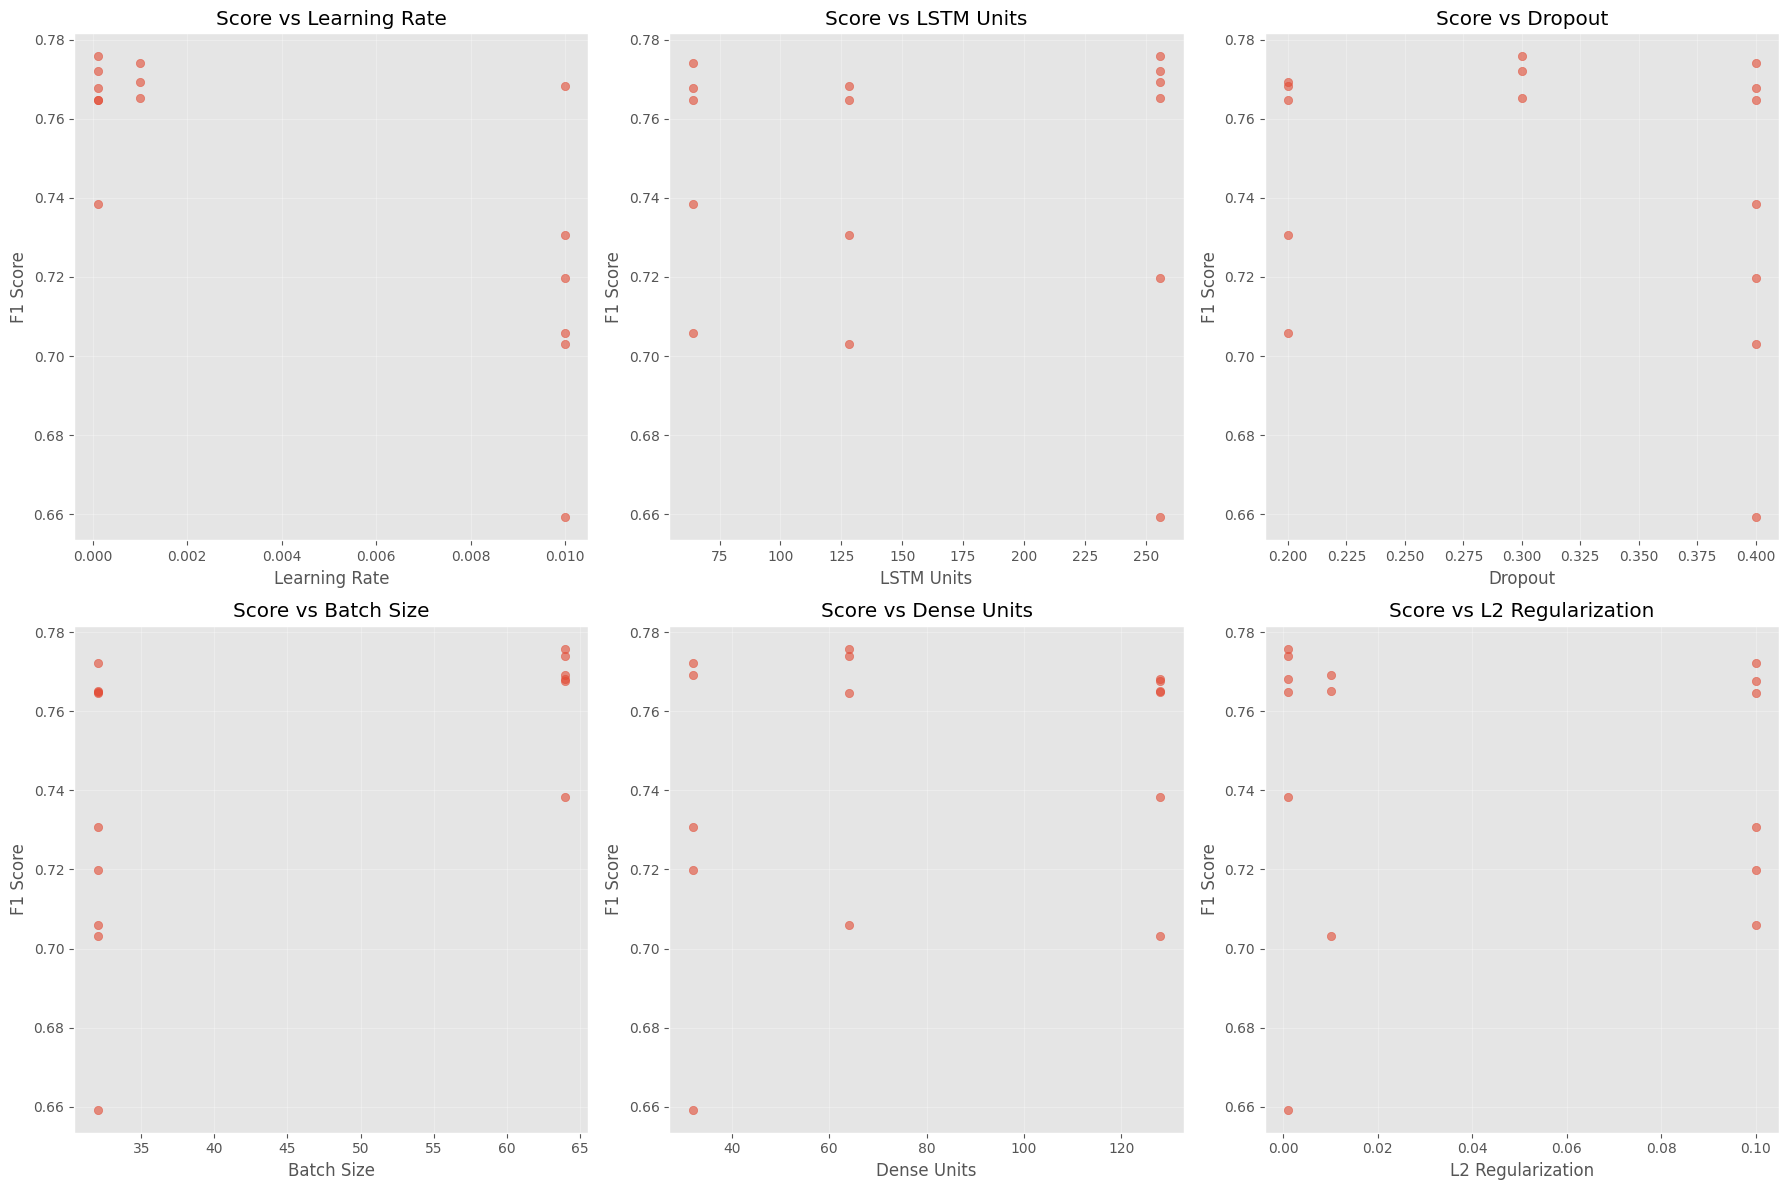

In [31]:
# Analyze and visualize hyperparameter tuning results
def analyze_tuning_results(all_results, scoring_metric='f1_score'):
    """
    Analyze and visualize hyperparameter tuning results.
    """
    if not all_results:
        print("No results to analyze.")
        return

    # Create DataFrame from results
    results_data = []
    for result in all_results:
        config = result['config']
        metrics = result['metrics']
        test_metrics = metrics.get('test', {})

        row = {
            'iteration': result['iteration'],
            'score': result['score'],
            'units': config.get('units'),
            'max_length': config.get('max_length'),
            'batch_size': config.get('batch_size'),
            'learning_rate': config.get('learning_rate'),
            'dropout': config.get('dropout'),
            'dense_units': config.get('dense_units'),
            'l2_reg': config.get('l2_reg'),
            'accuracy': test_metrics.get('accuracy'),
            'f1_score': test_metrics.get('f1_score'),
            'roc_auc': test_metrics.get('roc_auc'),
            'precision': test_metrics.get('precision'),
            'recall': test_metrics.get('recall')
        }
        results_data.append(row)

    results_df = pd.DataFrame(results_data)

    # Sort by score
    results_df = results_df.sort_values('score', ascending=False)

    print("\n=== Top 5 Hyperparameter Combinations ===")
    display(results_df.head(5)[['iteration', 'score', 'units', 'max_length',
                                  'batch_size', 'learning_rate', 'dropout',
                                  'dense_units', 'l2_reg', 'accuracy', 'f1_score', 'roc_auc']])

    # Visualize parameter importance
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Score vs Learning Rate
    axes[0, 0].scatter(results_df['learning_rate'], results_df['score'], alpha=0.6)
    axes[0, 0].set_xlabel('Learning Rate')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_title('Score vs Learning Rate')
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Score vs LSTM Units
    axes[0, 1].scatter(results_df['units'], results_df['score'], alpha=0.6)
    axes[0, 1].set_xlabel('LSTM Units')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('Score vs LSTM Units')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Score vs Dropout
    axes[0, 2].scatter(results_df['dropout'], results_df['score'], alpha=0.6)
    axes[0, 2].set_xlabel('Dropout')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].set_title('Score vs Dropout')
    axes[0, 2].grid(True, alpha=0.3)

    # Plot 4: Score vs Batch Size
    axes[1, 0].scatter(results_df['batch_size'], results_df['score'], alpha=0.6)
    axes[1, 0].set_xlabel('Batch Size')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title('Score vs Batch Size')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 5: Score vs Dense Units
    axes[1, 1].scatter(results_df['dense_units'], results_df['score'], alpha=0.6)
    axes[1, 1].set_xlabel('Dense Units')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].set_title('Score vs Dense Units')
    axes[1, 1].grid(True, alpha=0.3)

    # Plot 6: Score vs L2 Regularization
    axes[1, 2].scatter(results_df['l2_reg'], results_df['score'], alpha=0.6)
    axes[1, 2].set_xlabel('L2 Regularization')
    axes[1, 2].set_ylabel('F1 Score')
    axes[1, 2].set_title('Score vs L2 Regularization')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()

    # Save and log to MLflow
    plot_path = '../artifacts/hyperparameter_analysis.png'
    plt.savefig(plot_path)
    try:
        mlflow.log_artifact(plot_path, artifact_path="hyperparameter_tuning")
        print(f"\nVisualization saved to {plot_path} and logged to MLflow")
    except Exception as e:
        print(f"Couldn't log to MLflow: {e}")

    plt.show()

    return results_df

# Analyze results
if all_results:
    tuning_results_df = analyze_tuning_results(all_results, scoring_metric='f1_score')
else:
    print("No results to analyze.")


=== Comparison: Baseline vs Tuned Model ===

Performance Comparison:


,Metric,Baseline,Tuned,Improvement,Improvement %
0,Accuracy,0.747300,0.779000,0.031700,4.24
1,F1 Score,0.703160,0.775771,0.072611,10.33
2,ROC AUC,0.842587,0.859147,0.016560,1.97
3,Precision,0.851978,0.787273,-0.064705,-7.59
4,Recall,0.598600,0.764600,0.166000,27.73
5,Specificity,0.896000,0.793400,-0.102600,-11.45



Comparison plot saved to ../artifacts/baseline_vs_tuned_comparison.png and logged to MLflow


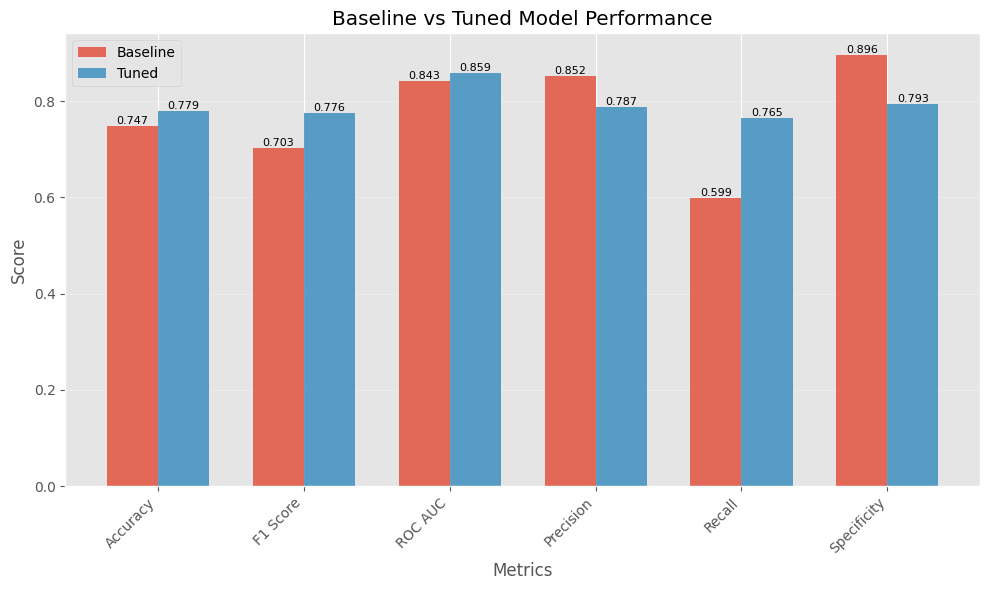


=== Best Hyperparameters Found ===
  model_type: Bidirectional_GRU
  embedding: glove
  epochs: 10
  batch_size: 64
  units: 256
  embedding_dim: 100
  max_length: 120
  learning_rate: 0.0001
  dropout: 0.3
  dense_units: 64
  l2_reg: 0.001


In [32]:
# Compare baseline vs tuned model
print("=== Comparison: Baseline vs Tuned Model ===\n")

# Get baseline metrics (from Cell 18)
baseline_metrics = {}
if best_models:
    # Find the Bidirectional_GRU with glove baseline
    experiment = mlflow.get_experiment_by_name(experiment_name)
    runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
    valid_runs = runs[runs['params.model_type'].notna() & runs['params.embedding'].notna()]

    baseline_run = valid_runs[
        (valid_runs['params.model_type'] == 'Bidirectional_GRU') &
        (valid_runs['params.embedding'] == 'glove')
    ]

    if not baseline_run.empty:
        baseline_run = baseline_run.iloc[0]
        baseline_metrics = {
            'accuracy': baseline_run.get('metrics.test_accuracy', np.nan),
            'f1_score': baseline_run.get('metrics.test_f1_score', np.nan),
            'roc_auc': baseline_run.get('metrics.test_roc_auc', np.nan),
            'precision': baseline_run.get('metrics.test_precision', np.nan),
            'recall': baseline_run.get('metrics.test_recall', np.nan),
            'specificity': baseline_run.get('metrics.test_specificity', np.nan)
        }

# Get tuned model metrics
tuned_metrics = best_metrics.get('test', {}) if best_metrics else {}

# Create comparison DataFrame
comparison_data = {
    'Metric': ['Accuracy', 'F1 Score', 'ROC AUC', 'Precision', 'Recall', 'Specificity'],
    'Baseline': [
        baseline_metrics.get('accuracy', np.nan),
        baseline_metrics.get('f1_score', np.nan),
        baseline_metrics.get('roc_auc', np.nan),
        baseline_metrics.get('precision', np.nan),
        baseline_metrics.get('recall', np.nan),
        baseline_metrics.get('specificity', np.nan)
    ],
    'Tuned': [
        tuned_metrics.get('accuracy', np.nan),
        tuned_metrics.get('f1_score', np.nan),
        tuned_metrics.get('roc_auc', np.nan),
        tuned_metrics.get('precision', np.nan),
        tuned_metrics.get('recall', np.nan),
        tuned_metrics.get('specificity', np.nan)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Improvement'] = comparison_df['Tuned'] - comparison_df['Baseline']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Baseline'] * 100).round(2)

print("Performance Comparison:")
display(comparison_df)

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Baseline'], width, label='Baseline', alpha=0.8)
bars2 = ax.bar(x + width/2, comparison_df['Tuned'], width, label='Tuned', alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Baseline vs Tuned Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=8)

plt.tight_layout()

# Save and log
comparison_path = '../artifacts/baseline_vs_tuned_comparison.png'
plt.savefig(comparison_path)
try:
    mlflow.log_artifact(comparison_path, artifact_path="hyperparameter_tuning")
    print(f"\nComparison plot saved to {comparison_path} and logged to MLflow")
except Exception as e:
    print(f"Couldn't log to MLflow: {e}")

plt.show()

# Print best configuration
print("\n=== Best Hyperparameters Found ===")
for key, value in best_config.items():
    print(f"  {key}: {value}")


In [ ]:
# Save best model in ../backend/model/


A

NameError: name 'tuned_model' is not defined

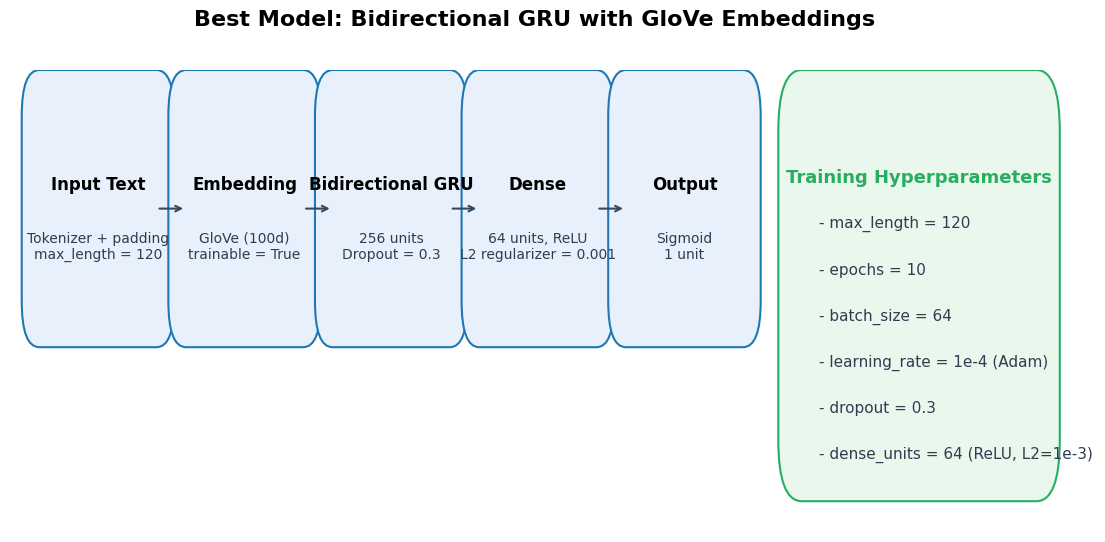

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch


def plot_best_bidirectional_gru_diagram():
    layers = [
        ("Input Text", "Tokenizer + padding\nmax_length = 120"),
        ("Embedding", "GloVe (100d)\ntrainable = True"),
        ("Bidirectional GRU", "256 units\nDropout = 0.3"),
        ("Dense", "64 units, ReLU\nL2 regularizer = 0.001"),
        ("Output", "Sigmoid\n1 unit")
    ]
    hyperparams = [
        "max_length = 120",
        "epochs = 10",
        "batch_size = 64",
        "learning_rate = 1e-4 (Adam)",
        "dropout = 0.3",
        "dense_units = 64 (ReLU, L2=1e-3)"
    ]

    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis("off")
    ax.set_xlim(-0.5, 18)
    ax.set_ylim(0, 3)

    box_width = 2.0
    box_height = 1.2
    spacing = 0.5
    start_x = 0.0
    y = 1.5

    for i, (title, subtitle) in enumerate(layers):
        x = start_x + i * (box_width + spacing)
        box = FancyBboxPatch(
            (x, y),
            box_width,
            box_height,
            boxstyle="round,pad=0.3",
            linewidth=1.5,
            edgecolor="#1f77b4",
            facecolor="#e8f1fb"
        )
        ax.add_patch(box)
        ax.text(
            x + box_width / 2,
            y + 0.75,
            title,
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold"
        )
        ax.text(
            x + box_width / 2,
            y + 0.35,
            subtitle,
            ha="center",
            va="center",
            fontsize=10,
            color="#2c3e50"
        )
        if i < len(layers) - 1:
            next_x = start_x + (i + 1) * (box_width + spacing)
            ax.annotate(
                "",
                xy=(next_x, y + box_height / 2),
                xytext=(x + box_width, y + box_height / 2),
                arrowprops=dict(arrowstyle="->", linewidth=1.5, color="#34495e")
            )

    hyper_box = FancyBboxPatch(
        (start_x + len(layers) * (box_width + spacing) + 0.5, 0.6),
        4.0,
        2.0,
        boxstyle="round,pad=0.4",
        linewidth=1.5,
        edgecolor="#27ae60",
        facecolor="#eaf7ed"
    )
    ax.add_patch(hyper_box)
    ax.text(
        start_x + len(layers) * (box_width + spacing) + 2.5,
        2.3,
        "Training Hyperparameters",
        ha="center",
        va="center",
        fontsize=13,
        fontweight="bold",
        color="#27ae60"
    )
    for idx, line in enumerate(hyperparams):
        ax.text(
            start_x + len(layers) * (box_width + spacing) + 0.8,
            2.0 - idx * 0.3,
            f"- {line}",
            ha="left",
            va="center",
            fontsize=11,
            color="#2c3e50"
        )

    fig.suptitle("Best Model: Bidirectional GRU with GloVe Embeddings", fontsize=16, fontweight="bold")
    plt.show()


plot_best_bidirectional_gru_diagram()
